In [3]:
import pandas as pd

# Load the CSVs
import pandas as pd

users = pd.read_csv('/Users/cicisofia/Downloads/takehome_users.csv', encoding='latin1')
engagement = pd.read_csv('/Users/cicisofia/Downloads/takehome_user_engagement.csv')


# Check the basic structure
print(users.shape)
print(engagement.shape)
users.head()
engagement.head()


(12000, 10)
(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
# Make sure timestamp is datetime
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

# Create an adopted user set
adopted_user_ids = set()

# Group by user
user_groups = engagement.groupby('user_id')['time_stamp'].apply(list)

for user_id, dates in user_groups.items():
    dates = sorted(dates)
    for i in range(len(dates) - 2):
        # Check if 3 logins in 7-day window
        if (dates[i+2] - dates[i]).days <= 7:
            adopted_user_ids.add(user_id)
            break

# Add a new column to users dataframe
users['adopted'] = users['object_id'].isin(adopted_user_ids).astype(int)

# Check balance
users['adopted'].value_counts()


adopted
0    10344
1     1656
Name: count, dtype: int64

In [11]:
# Clean and convert datatypes
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s', errors='coerce')

# Time active (how long they’ve existed)
users['days_since_creation'] = (pd.Timestamp.now() - users['creation_time']).dt.days

# Invited or not
users['was_invited'] = users['invited_by_user_id'].notnull().astype(int)

# Encode creation source
users['creation_source_code'] = users['creation_source'].astype('category').cat.codes

# Select features
features = [
    'opted_in_to_mailing_list',
    'enabled_for_marketing_drip',
    'was_invited',
    'creation_source_code',
    'days_since_creation'
]

X = users[features]
y = users['adopted']

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model (can change to logistic regression if you want interpretability)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict + report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2063
           1       0.18      0.11      0.13       337

    accuracy                           0.81      2400
   macro avg       0.52      0.51      0.51      2400
weighted avg       0.77      0.81      0.78      2400



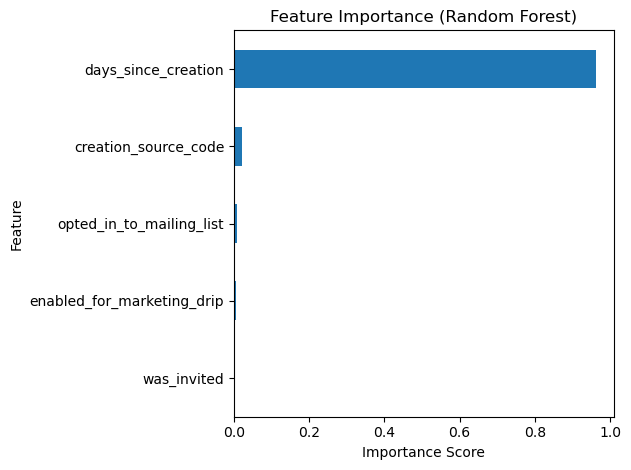

In [13]:
import matplotlib.pyplot as plt

# Show which features were most predictive
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [21]:

# Split the ORIGINAL data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train balanced model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.82      0.84      2063
           1       0.16      0.21      0.18       337

    accuracy                           0.74      2400
   macro avg       0.51      0.52      0.51      2400
weighted avg       0.77      0.74      0.75      2400



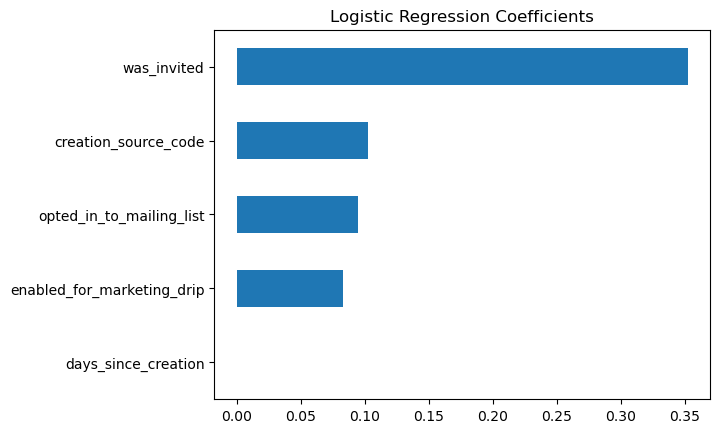

In [23]:

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train, y_train)

# Coefficients = feature influence
coef_df = pd.Series(log_reg.coef_[0], index=X.columns)
coef_df.sort_values().plot(kind='barh')
plt.title('Logistic Regression Coefficients')
plt.show()


In [37]:
# -------------------------------------------------------------
# BRIEF WRITEUP OF FINDINGS — USER ADOPTION ANALYSIS
# -------------------------------------------------------------

# GOAL:
# Identify which user attributes predict whether a user will become an "adopted user",
# defined as someone who logged in on three separate days within a single seven-day period.

# DATA USED:
# - takehome_users.csv (user metadata, 12,000 users)
# - takehome_user_engagement.csv (raw engagement logs, 207,917 records)

# STEP 1: DEFINE ADOPTED USERS
# - Grouped login events by user and checked for any rolling 7-day window
#   with 3 distinct login dates.
# - Created binary label 'adopted' (1 = adopted, 0 = not adopted)
# - 1,656 users were labeled as adopted.

# STEP 2: FEATURE ENGINEERING
# From takehome_users.csv, generated:
# - creation_source_code: Encoded source of signup (website, invite, Google, etc.)
# - was_invited: Binary flag if user was invited by another
# - opted_in_to_mailing_list: Binary
# - enabled_for_marketing_drip: Binary
# - days_since_creation: Time between account creation and current date

# STEP 3: MODELING APPROACHES
# - Ran both Logistic Regression (for interpretability)
#   and Random Forest (for performance and feature importance).
# - Used class_weight='balanced' due to adoption class imbalance (~14% adopted).
# - Evaluated models using precision, recall, and F1-score on class 1 (adopted users).

# STEP 4: INSIGHTS
# - Logistic Regression: 'was_invited' was the strongest positive predictor of adoption.
# - Random Forest: 'days_since_creation' dominated importance, likely due to 
#   older users having more time to meet the adoption criteria (passive time effect).
# - Marketing indicators and signup source showed small positive effects.

# STEP 5: FACTORS CONSIDERED BUT NOT USED
# - org_id: Considered but excluded due to lack of org-level engagement features.
# - invited_by_user_id (raw): Converted to 'was_invited' binary flag instead.
# - last_session_creation_time: Excluded due to potential leakage
#   (wouldn’t be known at time of signup).

# STEP 6: FURTHER RESEARCH RECOMMENDATIONS
# - Add early-product behavior (e.g. features clicked, team activity) to model short-term adoption
# - Analyze adoption trends at the org level (e.g. do active orgs boost user retention?)
# - Explore time-aware modeling: predict adoption based on first 7 days of data only

# FINAL SUMMARY:
# The clearest actionable signal was that being invited by another user significantly increases 
# likelihood of adoption. Creation source and marketing engagement also help, while passive 
# features like account age can bias predictive models if not handled carefully.


